In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('..')
import random, math, os
import pyzx as zx
from fractions import Fraction
from pyzx.phasepoly import circuit_phase_polynomial_blocks, optimize_block
import numpy as np
%config InlineBackend.figure_format = 'svg'
zx.quantomatic.quantomatic_location = r'C:\Users\John\Desktop\scala.jar'

Circuit tof_4_before on 7 qubits with 85 gates.
        35 T-like gates
        50 Cliffords among which 
        30 2-qubit gates and 20 Hadamard gates.
23


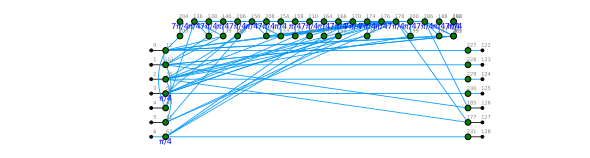

In [25]:
#g = zx.generate.identity(1,2)
#g = zx.quantomatic.edit_graph(g)
#circ_name = r'../circuits/toobig/hwb12.qc'
circ_name = r'../circuits/Fast/tof_4_before'
c_orig = zx.Circuit.load(circ_name).to_basic_gates()
print(c_orig.stats())
g = c_orig.to_graph()
#g = zx.generate.cliffordT(4,100, p_t=0.2)
zx.simplify.full_reduce(g,quiet=True)
g.normalise()
print(zx.tcount(g))
zx.draw(g,labels=True)

11 89
11 19
9 35
9 19


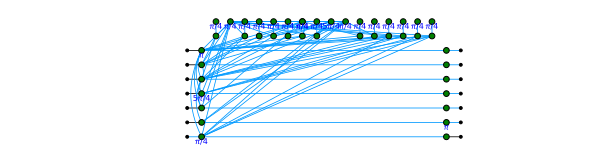

In [26]:
from pyzx.circuit import ZPhase
from pyzx.linalg import Mat2
from pyzx.todd import todd_iter, MultiLinearPoly
#zx.todd.TOPT_LOCATION = os.path.expanduser("~/projects/pyzx/TOpt")
zx.todd.USE_REED_MULLER = False

def todd_on_graph(g):
    gadgets = {}
    t_nodes = []
    for v in g.vertices():
        if v not in g.inputs and v not in g.outputs and len(list(g.neighbours(v)))==1:
            if g.phase(v) != 0 and g.phase(v).denominator != 4: continue
            n = list(g.neighbours(v))[0]
            tgts = frozenset(set(g.neighbours(n)).difference({v}))
            gadgets[tgts] = (n,v)
#             for t in tgts:
#                 if t not in targets: targets.append(t)
        if g.phase(v) != 0 and g.phase(v).denominator == 4:
            t_nodes.append(v)
    
    if not gadgets:
        print("No phase gadgets found")
        return
    variables = set()
    for par in gadgets.keys():
        variables.update(par)
    
    for v in variables:
        if v in t_nodes:
            gadgets[frozenset({v})] = (v,v)
    
    targets = list(variables)
    n = len(targets)
#     print("variables: ", n)
#     print(targets)
#     print("parities: ", len(gadgets))
#     print(gadgets)
    #print("t_nodes: ", len(t_nodes))

    cols = []
    for par, (_,v) in gadgets.items():
        col = [0]*n
        for t in par:
            col[targets.index(t)] = 1
        phase = g.phase(v)
        for i in range(phase.numerator): cols.append(col)
        #cols.append(col)
    parmatrix = Mat2(cols).transpose()
    print(parmatrix.rows(), parmatrix.cols())
    #print(parmatrix)
    m2 = todd_iter(parmatrix)
    print(m2.rows(), m2.cols())
    
    newgadgets = []
    phases = dict()
    for col in m2.transpose().data:
        if sum(col) == 1:
            i = next(i for i,a in enumerate(col) if a)
            v = targets[i]
            if v in t_nodes:
                phases[v] = Fraction(1,4)
            else:
                phases[v] = g.phase(v) + Fraction(1,4)
        else:
            newgadgets.append(frozenset([targets[i] for i,a in enumerate(col) if a]))
    
    p = zx.todd.MultiLinearPoly()
    p.add_par_matrix(parmatrix,False)
    p.add_par_matrix(m2,True)
    correction = p.to_clifford()
    add_czs = {}
    for clif in correction:
        if isinstance(clif, ZPhase):
            v = targets[clif.target]
            if v in phases:
                phases[v] += clif.phase
            else:
                if v in t_nodes:
                    phases[v] = clif.phase
                else:
                    phases[v] = g.phase(v) + clif.phase
        elif clif.name == 'CZ':
            v1,v2 = targets[clif.control], targets[clif.target]
            add_czs[(v1,v2)] = (0,1)
    
    for v in targets:
        if v in phases:
            g.set_phase(v, phases[v])
        else:
            if v in t_nodes:
                g.set_phase(v, 0)
    g.add_edge_table(add_czs)
    
    rs = g.rows()
    positions = set()
    for gadget, (n,v) in gadgets.items():
        if len(gadget) == 1: continue # T-node
        if gadget in newgadgets:
            positions.add(rs[v])
            g.set_phase(v, Fraction(1,4))
            newgadgets.remove(gadget)
        else:
            g.remove_vertices((n,v))
    
    edges = []
    for par in newgadgets:
        pos = sum(rs[t] for t in par)/len(par) + 0.5
        while pos in positions: pos += 0.5
        n = g.add_vertex(1, -1, pos)
        v = g.add_vertex(1, -2, pos, phase=Fraction(1,4))
        edges.append((n,v))
        positions.add(pos)
        for t in par: edges.append((n,t))
    g.add_edges(edges, 2)
    

g2 = g.copy()
#display(zx.draw(g2,labels=True))
todd_on_graph(g2)
zx.full_reduce(g2)
todd_on_graph(g2)
zx.full_reduce(g2)
g2.normalise()
zx.draw(g2)

In [27]:
g3 = g2.copy()
c2 = zx.extract.streaming_extract(g3)
zx.draw(c2)

Exception: Did not find any completely reducable row

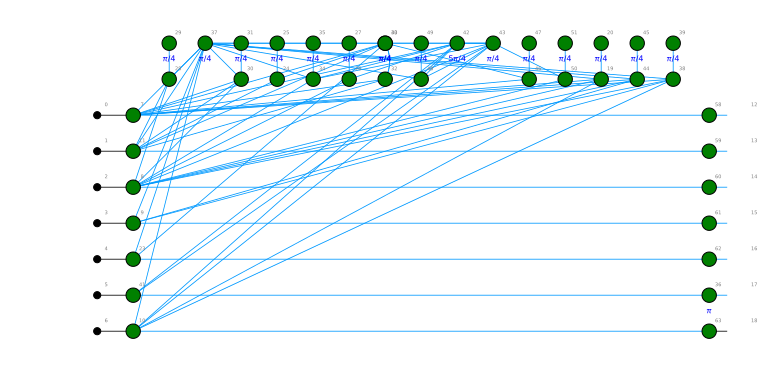

In [29]:
#zx.simplify.id_simp(g3, quiet=True)
g3.normalise()
zx.draw(g3, labels=True, figsize=(10,5))

In [46]:
g = g3
left = [v for v in g.vertices() if g.row(v) == 1]
extra = [37, 42, 43]
left = left
right = set()
for v in left: right.update(w for w in g.neighbours(v) if g.row(w)>1)
right = list(right)
for w in extra:
    right.remove(w)
    right.append(w)
m = zx.extract.bi_adj(g, right, left)
print(m.rank())
m.gauss(full_reduce=True)
print(sum(1 for row in m.data if sum(row)==1))
m

7
0


[ 1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  1  0  1  0  1  1 ]
[ 0  1  0  1  0  0  0  0  0  0  1  1  0  1  1  0  0  0  1  1  0  1 ]
[ 0  0  1  1  0  1  1  0  0  0  0  1  1  1  0  1  0  1  0  0  1  1 ]
[ 0  0  0  0  1  1  0  0  0  0  1  1  0  1  0  0  0  1  1  1  0  1 ]
[ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  1 ]
[ 0  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  1  0  0  1  0  0 ]
[ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  1  0  0 ]

In [31]:
m.rank()

7

In [117]:
seed = 364195
random.seed(seed)
qubits = 3
depth = 80
circ = zx.generate.cliffordT(qubits, depth, p_t = 0.2)
g = circ.copy()
zx.simplify.full_reduce(g)
g.normalise()
zx.draw(g)
c = zx.extract.streaming_extract(g, quiet=False)

Greedy reduction with 1 CNOTs
Greedy reduction with 1 CNOTs
Greedy reduction with 1 CNOTs
No cutting necessary
Complicated phase gadget


In [118]:
zx.compare_tensors(circ, c)

True

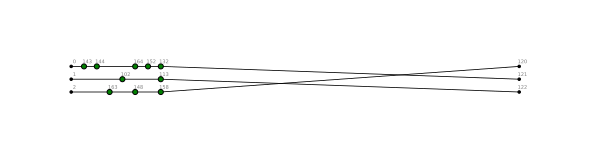

In [119]:
zx.draw(g, labels=True)

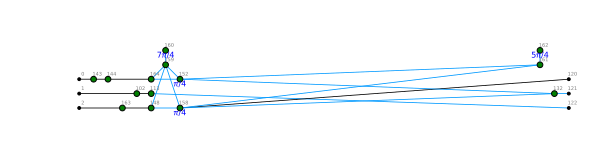

In [114]:
zx.draw(g, labels=True)

In [98]:
c.gates

[ZPhase(1,phase=5/4),
 HAD(0),
 ZPhase(2,phase=1),
 CZ(1,0),
 CZ(1,2),
 CZ(0,2),
 HAD(0),
 ZPhase(0,phase=3/4),
 CZ(0,2),
 CNOT(0,1),
 HAD(0),
 ZPhase(0,phase=1/4),
 CZ(2,0),
 HAD(2),
 ZPhase(2,phase=3/4),
 ParityPhase(5/4, 2, 1),
 CNOT(1,0),
 HAD(1),
 CNOT(1,0),
 CNOT(0,1),
 HAD(0),
 ZPhase(0,phase=-1/2),
 HAD(0),
 HAD(2),
 ZPhase(2,phase=-1/2),
 HAD(2),
 ParityPhase(1/4, 0, 2),
 HAD(0),
 ZPhase(0,phase=1/2),
 HAD(2),
 ZPhase(2,phase=1/2),
 ZPhase(0,phase=1/4),
 ZPhase(2,phase=1/4),
 ParityPhase(5/4, 0, 2),
 HAD(0),
 CZ(0,2),
 HAD(1),
 HAD(0),
 SWAP(0,2),
 SWAP(1,2)]

In [22]:
g4 = g3.copy()
for e in g4.edges(): g4.set_edge_type(e, 1)
zx.quantomatic.edit_graph(g4)

Opening Quantomatic...
Done


Graph(38 vertices, 53 edges)

In [97]:
c3 = zx.optimize.basic_optimization(c2.to_basic_gates())
print(c3.stats())

Circuit  on 12 qubits with 301 gates.
        35 T-like gates
        266 Cliffords among which 
        246 2-qubit gates and 8 Hadamard gates.


In [24]:
d = {1: 2, 5: 3}
max(d.values())

3

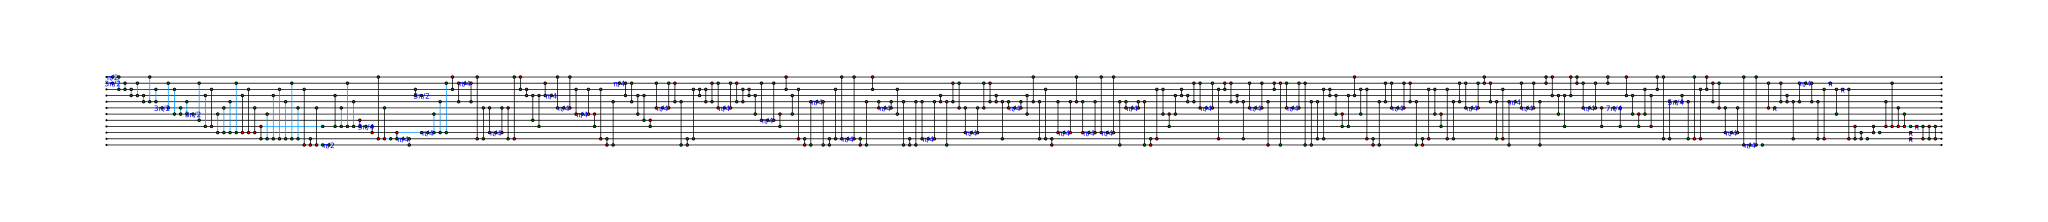

In [99]:
zx.draw(c3, figsize=(30,3))

In [95]:
zx.compare_tensors(c_orig, c2)

KeyboardInterrupt: 

In [22]:
import subprocess
import os
s = subprocess.check_output(["../TOpt", "gsm","../testmatrix.gsm"]).decode()

In [4]:
g2 = g.copy()
zx.simplify.to_rg(g2)
zx.quantomatic.edit_graph(g2)

Opening Quantomatic...
Done


Graph(13 vertices, 21 edges)

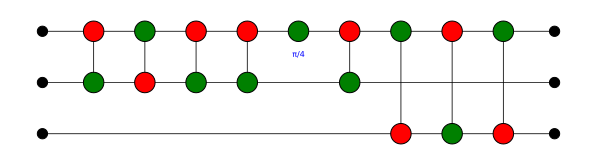

In [220]:
c = zx.Circuit(3)
qubits = c.qubits
c.add_gate("SWAP",1,0)
c.add_gate("ParityPhase", Fraction(1,4),1,0)
c.add_gate("SWAP",0,2)
zx.draw(c)

1.

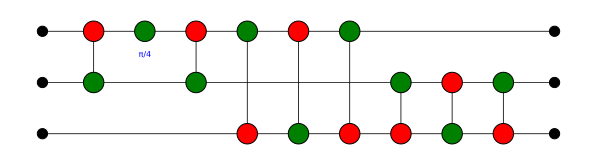

In [228]:
o = zx.optimize.Optimizer(c.to_basic_gates())
circuit, correction = o.parse_circuit(separate_correction=True, quiet=False)
zx.draw(zx.optimize.phase_block_optimize(c.to_basic_gates()))

In [225]:
correction

[SWAP(0,2), SWAP(1,2)]

In [11]:
from pyzx.circuit import SWAP
qubits = 3
permutation = {i:i for i in range(qubits)}
correction = [SWAP(0,1),SWAP(0,2)]
for g in correction:
    if g.name == 'SWAP':
        a = permutation[g.control]
        b = permutation[g.target]
        permutation[g.control] = b
        permutation[g.target] = a
    elif g.name == 'NOT':
        nots.append(g)
    else:
        raise TypeError("Illegal correction {}".format(str(g)))

permutation = {v:k for k,v in permutation.items()}
zx.extract.permutation_as_swaps(permutation)
#permutation

[(0, 2), (1, 2)]

In [227]:
permutation = {i:i for i in range(qubits)}
nots = []
for g in correction:
    if g.name == 'SWAP':
        a = permutation[g.control]
        b = permutation[g.target]
        permutation[g.control] = b
        permutation[g.target] = a
    elif g.name == 'NOT':
        nots.append(g)
    else:
        raise TypeError("Illegal correction {}".format(str(g)))
permutation = {v:k for k,v in permutation.items()}
permutation

{2: 0, 0: 1, 1: 2}

In [198]:
phase_poly, parity_polys = zx.todd.phase_gates_to_poly(c.to_basic_gates().gates, c.qubits)
phase_poly, parity_polys

(x0@x1, [x2, x0, x1])

In [199]:
from pyzx.phasepoly import parity_network
m = phase_poly.to_par_matrix()
newgates = []
parities = []
for col in m.transpose().data:
    #if sum(col) == 1:
    #    newgates.append(T(next(i for i in range(qubits) if col[i])))
    #else:
    parities.append(col)

cnots = parity_network(c.qubits, parities)
parities

[[1, 1, 0]]

In [164]:
cnots

[CNOT(1,0)]

In [200]:
m = zx.Mat2.id(c.qubits)
for cnot in cnots:
    m.row_add(cnot.control, cnot.target)
m

[ 1  1  0 ]
[ 0  1  0 ]
[ 0  0  1 ]

In [166]:
m.to_cnots()

[CNOT(0,1)]

In [201]:
data = []
for p in parity_polys:
    l = [int(i in p.par) for i in range(c.qubits)]
    data.append(l)

m2 = zx.Mat2(data)
m2

[ 0  0  1 ]
[ 1  0  0 ]
[ 0  1  0 ]

In [202]:
target_matrix = zx.Mat2(data) * m.inverse()
target_matrix

[ 0  0  1 ]
[ 1  1  0 ]
[ 0  1  0 ]

In [207]:
perm = zx.linalg.column_optimal_swap(target_matrix.transpose())
swaps = zx.extract.permutation_as_swaps(perm)
m2 = target_matrix.copy()
for a,b in swaps:
    m2.row_swap(a,b)

inv = {v:k for k,v in perm.items()}
m2

[ 1  1  0 ]
[ 0  1  0 ]
[ 0  0  1 ]

In [208]:
trueswaps = zx.extract.permutation_as_swaps(inv)
trueswaps

[(0, 2), (1, 2)]

In [194]:
perm, swaps

({3: 0, 0: 1, 1: 2, 2: 3}, [(0, 3), (1, 3), (2, 3)])

In [205]:
gates = m2.to_cnots(optimize=True)
gates

[CNOT(0,1)]

In [56]:
def generate_parities(targets):
    parities = set()
    for i in range(4):
        a = targets[i]
        parities.add(frozenset([a]))
        for j in range(i+1,4):
            b = targets[j]
            parities.add(frozenset([a,b]))
            for k in range(j+1,4):
                c = targets[k]
                parities.add(frozenset([a,b,c]))
                for l in range(k+1,4):
                    d = targets[l]
                    parities.add(frozenset([a,b,c,d]))
    return parities

s1 = generate_parities([1,2,3,4])
s2 = generate_parities([1,3,4,5])
s3 = generate_parities([1,2,4,5])
#s5 = generate_parities([1,2,3,5])
s1.symmetric_difference(s2).symmetric_difference(s3)#.symmetric_difference(s4))#.symmetric_difference(s5)

{frozenset({1, 2, 3, 4}),
 frozenset({3, 5}),
 frozenset({1, 3, 5}),
 frozenset({2, 3}),
 frozenset({4}),
 frozenset({2, 3, 4}),
 frozenset({2, 5}),
 frozenset({1}),
 frozenset({1, 2, 4, 5}),
 frozenset({1, 2, 3}),
 frozenset({3, 4, 5}),
 frozenset({1, 4}),
 frozenset({1, 3, 4, 5}),
 frozenset({1, 2, 5}),
 frozenset({2, 4, 5})}

In [ ]:
[ 1  1  0  0  1  0  1  0 ]
[ 1  1  1  0  0  1  0  0 ]
[ 0  1  0  1  1  1  0  0 ]
[ 1  0  0  0  1  1  0  1 ]
[ 1  0  1  1  1  0  0  0 ]

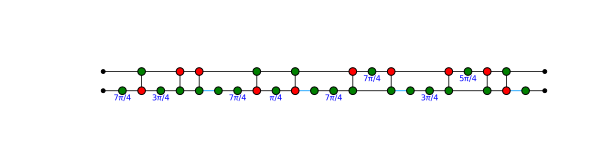

In [5]:
g = zx.generate.circuit_identity_commuting_controls(Fraction(1,4),Fraction(1,4))
zx.simplify.full_reduce(g)
c = zx.extract.streaming_extract(g).to_basic_gates()
c2, blocks = circuit_phase_polynomial_blocks(c,optimize=True)
c3, blocks = circuit_phase_polynomial_blocks(c2,optimize=True)
zx.draw(c3)

[]


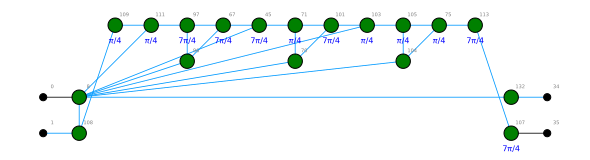

In [39]:
#c = generate_identity(Fraction(5,4),Fraction(7,4))
g = c.to_graph()
zx.simplify.full_reduce(g)
zx.simplify.full_reduce(g)
# zx.simplify.gadgetize(g)
# edges = [(49,55),(55,49),(59,65),(65,59)]
# zx.simplify.pivot_simp(g,matchf=lambda e: e in edges)
# zx.simplify.id_simp(g)
m = zx.rules.match_gadgets_phasepoly(g)
print(m)
#print(alpha, beta, [g.phase(v).numerator for v in g.vertices() if g.phase(v) != 0 and g.phase(v).denominator!=1])
#zx.gadget_simp(g)
# zx.simplify.id_simp(g)
#zx.full_reduce(g)
g.normalise()
zx.draw(g,labels=True)

In [35]:
zx.compare_tensors(g.to_tensor(), zx.generate.identity(2).to_tensor())

True

In [31]:
zx.quantomatic.edit_graph(g)

Opening Quantomatic...
Done


Graph(18 vertices, 23 edges)

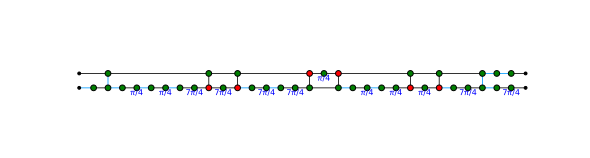

In [36]:
g2 = g.copy()
c2 = zx.extract.streaming_extract(g2)
zx.draw(c2.to_graph())

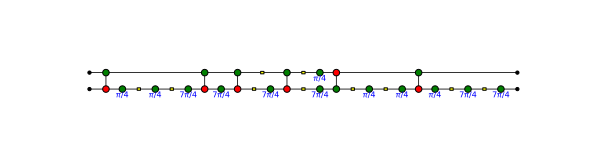

In [37]:
c3, blocks = circuit_phase_polynomial_blocks(c2.to_basic_gates(),optimize=True)
c4, blocks = circuit_phase_polynomial_blocks(c3,optimize=True)
g = c4.to_graph()
zx.simplify.id_simp(g,quiet=True)
zx.draw(g,h_edge_draw='box')

In [42]:
zx.compare_tensors(c4,zx.identity(2))

True

In [156]:
g = zx.generate.identity(1,3)
g = zx.quantomatic.edit_graph(g)

Opening Quantomatic...
Done


In [21]:
a = zx.Circuit(2)
a.add_gate("CZ",0,1)
a.add_gate("CNOT",0,1)
b = zx.Circuit(2)
b.add_gate("S",0)
b.add_gate("S",1)
b.add_gate("CNOT",0,1)
b.add_gate("S",1, adjoint=True)
zx.compare_tensors(a,b)

True

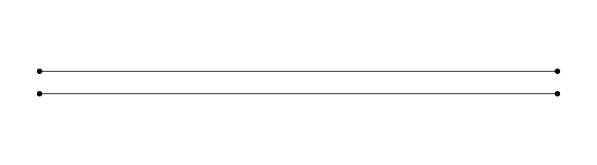

In [49]:
alpha = Fraction(3,5)
beta= Fraction(5,7)

c = zx.Circuit(2)
c.add_gate("XPhase", 1, alpha)
c.add_gate("ZPhase", 1, beta)
c.add_gate("XPhase", 1, alpha)
c.add_gate("NOT", 0)
c.add_gate("NOT", 1)
c.add_gate("CNOT",0,1)
c.add_gate("XPhase", 1, -alpha)
c.add_gate("NOT", 1)
c.add_gate("ZPhase", 1, -beta)
c.add_gate("XPhase", 1, -alpha)
c.add_gate("CNOT",0,1)
c.add_gate("NOT", 0)
c.add_gate("NOT", 1)
c.add_circuit(c)
g = c.to_graph()
zx.full_reduce(g)
zx.draw(g)